----

# PyEarthScience: Hovmöller Plot

Citation from Wkipedia: https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram

> "A Hovmöller diagram is a common way of plotting meteorological data to highlight 
> the behavior of waves, particularly tropical waves. The axes of Hovmöller diagrams 
> depict changes over time of scalar quantities such as temperature, density, and 
> other values of constituents in the atmosphere or ocean, such as depth, height, or 
> pressure. Typically in that case, time is recorded along the abscissa, or x-axis, 
> while 'vertical' values (of depth, height, pressure, etc.) are plotted along the 
> ordinate, or y-axis.
> 
> The alternate orientation of axes may also be used, as a Hovmöller diagram may be 
> plotted for longitude or latitude on the abscissa and for (advancing) time on the 
> ordinate; then the contour values of a named physical field may be presented through 
> color or shading.
> 
> The Hovmöller diagram was introduced by Ernest Aabo Hovmöller (1912-2008), 
> a Danish meteorologist, in a paper published in 1949."

----

In this example we show how to generate a Hovmöller diagram (lon vs. time). 
This example uses a subset of CMIP5 northward wind data. 

Steps:

- open dataset
- read variable
- extract data for time, lat, lon slices, and level
- compute the weighted mean for latitude slice
- create datetime objects for axis labeling
- create two plots: one small map on top and the Hovmöller diagram

---- 

## Import packages

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Used data subset

Dataset CMIP5 MPI-ESM-LR historical variable: va (northward wind)

```
  lon :       0        to  358.125 by 1.875 degrees_east  circular
  lat :     -28.91149  to   28.91149 degrees_north
  plev : 100000        to   10 Pa
  time:  1980-01-01    to 1989-12-31
  
  va(time, plev, lat, lon)
```

In [2]:
ds = xr.open_dataset('../../data/va_CMIP5_hist_subset_1980-1984.nc')

## Select variable

Select variable va from dataset and convert the pressure levels from Pa to hPa and attach it to vnwind.

In [3]:
vnwind = ds.va

levels = ds.plev / 100
levels.attrs['units'] = 'hPa'

vnwind['plev'] = levels

## Define slices

Define the time and latitude slice, and the pressure level to be selected.


In [4]:
print('Start: ', ds.time[0].values, '   End: ', ds.time[-1].values, '   ntimes: ', len(ds.time))

Start:  1980-01-16T12:00:00.000000000    End:  1984-12-16T12:00:00.000000000    ntimes:  60


In [5]:
time1, time2 = ds.time[0].values, ds.time[-1].values

lat1, lat2 = -10., 10.
lon1, lon2 = 0., 358.125

time_slice = slice(time1, time2)
lat_slice  = slice(lat1, lat2)
lon_slice  = slice(lon1, lon2)

sel_lev = 300

## Extract data

Extract the data from the variable vnwind as defined before.


In [6]:
data = vnwind.sel(time=time_slice, plev=sel_lev, lat=lat_slice, lon=lon_slice)

## Compute weights


In [7]:
weights = np.cos(np.deg2rad(data.lat))
weights.name = "weights"

## Compute weighted data


In [8]:
data_weighted = data.weighted(weights)

## Compute mean over dimension lat


In [9]:
data_weighted_mean = data_weighted.mean('lat')
data_weighted_mean.name = 'va'

Print the minimum and maximum value of the data_weighted_mean array. We need this information for the contour lines later.

In [10]:
print('Data min:  ', data_weighted_mean.min().values, '   Data max: ', data_weighted_mean.max().values)

Data min:   -8.776162609060794    Data max:  8.852512636726722


## Define the value range for the contour lines levels.

In [11]:
clevs = np.arange(-10, 11, 1)

## Create datetime objects

Read the time coordinate values and convert them to a more readable format for y-axis labeling. Don't forget to select the same time slice as for the data array.


In [12]:
vtimes = vnwind.time.sel(time=time_slice).dt.strftime('%Y-%m').values

## Extract longitudes

Extract the longitudes for the chosen region. Don't forget to select the same lon slice as for the data array.


In [13]:
lons = vnwind.lon.sel(lon=lon_slice).values

## Create the plot

Create two plots: 

1. **map plot**
1. **Hovmöller plot**

In this case we use the gridspec method to set the ratio and the space between the two plots.

<br>

Text(1.0, 1.0, 'Time: 1980-01 to 1984-12')

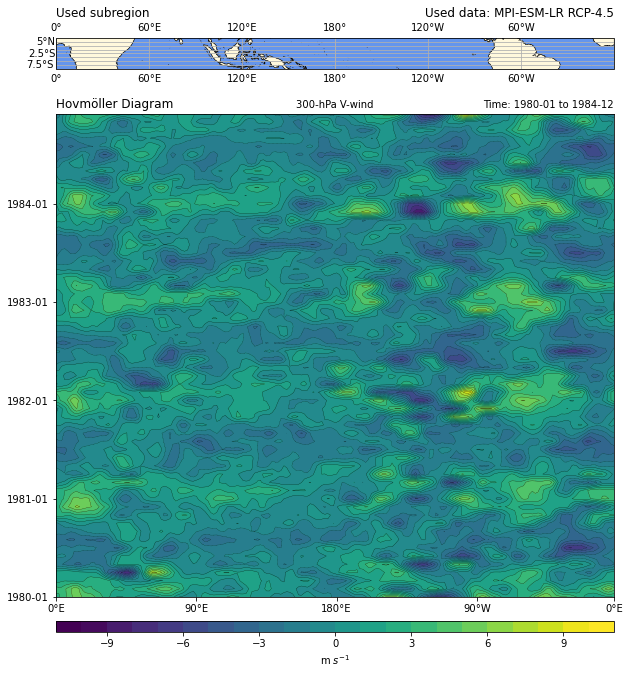

In [14]:
fig = plt.figure(figsize=(10, 13))

gs = gridspec.GridSpec(nrows=2, ncols=1, 
                       height_ratios=[1, 6], 
                       hspace=0.03)

#-- 1. map plot
proj = ccrs.PlateCarree(central_longitude=180.)

ax1 = fig.add_subplot(gs[0, 0], projection=proj)

ax1.set_extent([lon1, lon2, lat1, lat2])

ax1.coastlines(resolution='110m', lw=0.5)
ax1.gridlines(draw_labels=True, lw=0.1, edgecolor='lightgray', )

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', 
                                     scale='110m', 
                                     edgecolor='none', 
                                     facecolor=cfeature.COLORS['water'])

land = cfeature.NaturalEarthFeature('physical', 'land', 
                                    scale='50m', 
                                    edgecolor='k', 
                                    facecolor=cfeature.COLORS['land'],
                                    lw=0.3)

ax1.add_feature(ocean, facecolor='cornflowerblue', zorder=0)
ax1.add_feature(land, facecolor='cornsilk', zorder=0)

plt.title('Used subregion', loc='left')
plt.title('Used data: MPI-ESM-LR RCP-4.5', loc='right')

#-- 2. Hovmoeller diagram
ax2 = fig.add_subplot(gs[1, 0])

cfplot = ax2.contourf(lons, vtimes, data_weighted_mean, 
                      levels=clevs, 
                      cmap='viridis', 
                      extend='both')

clplot = ax2.contour(lons, vtimes, data_weighted_mean, 
                     levels=clevs, 
                     colors='k', 
                     linewidths=0.25)

cbar = plt.colorbar(cfplot, 
                    orientation='horizontal', 
                    pad=0.04, 
                    aspect=50, 
                    extendrect=True)
cbar.set_label('m $s^{-1}$')

ax2.set_xticks([0, 90, 180, 270, 358.125])
ax2.set_xticklabels([u'0\N{DEGREE SIGN}E',   u'90\N{DEGREE SIGN}E',
                     u'180\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}W',
                     u'0\N{DEGREE SIGN}E'])

ax2.set_yticks(vtimes[0::12])
ax2.set_yticklabels(vtimes[0::12])

plt.title(u'Hovmöller Diagram', loc='left')
plt.title(str(sel_lev)+'-hPa V-wind', loc='center', fontsize=10)
plt.title('Time: '+ vtimes[0] +' to '+ vtimes[-1], loc='right', fontsize=10)

#plt.savefig('plot_hovmoeller.png', bbox_inches='tight', dpi=100)